# 파이토치 CIFAR10 모델
- 코드 출처: https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

## modules import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

- 현재 GPU 설정

In [2]:
torch.cuda.is_available()

True

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [4]:
device

device(type='cuda')

## 전처리 설정

In [5]:
transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## 데이터 로드 및 확인

In [7]:
trainset = torchvision.datasets.CIFAR10(root='/data',
                                        train = True,
                                        download=True,
                                        transform = transform)

testset = torchvision.datasets.CIFAR10(root='/data',
                                        train = False,
                                        download=True,
                                        transform = transform)

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [8]:
train_loader = DataLoader(trainset, 
                          batch_size=4, 
                          shuffle=True, 
                          num_workers=2)

test_loader = DataLoader(testset, 
                          batch_size=4, 
                          shuffle=False, 
                          num_workers=2)

In [20]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

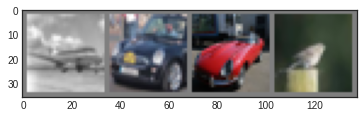

	plane 	car 	car 	bird


In [13]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(4)))

## 신경망 구성

In [14]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net().to(device)

## 손실함수와 옵티마이저

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

- 설명을 위해 `epochs=2`로 지정

In [16]:
for epoch in range(2):
  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
      running_loss = 0.0
      

Epoch: 1, Batch: 2000, Loss: 2.200222426056862
Epoch: 1, Batch: 4000, Loss: 1.849152677476406
Epoch: 1, Batch: 6000, Loss: 1.6789705818146468
Epoch: 1, Batch: 8000, Loss: 1.5819919228851795
Epoch: 1, Batch: 10000, Loss: 1.5140610827133059
Epoch: 1, Batch: 12000, Loss: 1.4672716802880168
Epoch: 2, Batch: 2000, Loss: 1.3993401479125023
Epoch: 2, Batch: 4000, Loss: 1.3802718474715947
Epoch: 2, Batch: 6000, Loss: 1.3605644741505385
Epoch: 2, Batch: 8000, Loss: 1.3238949730210006
Epoch: 2, Batch: 10000, Loss: 1.303539080876857
Epoch: 2, Batch: 12000, Loss: 1.277150814279914


## 모델의 저장 및 로드

In [17]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

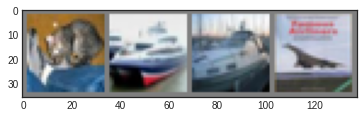

	cat 	ship 	ship 	plane


In [21]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(4)))

In [22]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트

In [23]:
outputs = net(images.to(device))

In [24]:
_, predicted = torch.max(outputs, 1)
print(' '.join('\t{}'.format(classes[predicted[j]]) for j in range(4)))

	cat 	car 	ship 	ship


In [25]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100 * correct / total)

55.79


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of {}: {}%'.format(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 56.5%
Accuracy of car: 67.0%
Accuracy of bird: 42.3%
Accuracy of cat: 52.5%
Accuracy of deer: 46.9%
Accuracy of dog: 31.9%
Accuracy of frog: 65.6%
Accuracy of horse: 54.5%
Accuracy of ship: 77.5%
Accuracy of truck: 63.2%
